In [1]:
import gym
import gym_snake
import numpy as np
import cv2 as cv
import torch
import random
import matplotlib.pyplot as plt

from helpers.feature_extraction import feature_vector, find_apple_coordinates_pixel_array, distances_to_walls
from helpers.genetic_algorithms import GameNet, create_mating_pool, create_population, calculate_fitness


# Construct Environment
env = gym.make('snake-v0')
env.grid_size = 15, 15
observation = env.reset()  # Constructs an instance of the game

# Controller
game_controller = env.controller

# Grid
grid_object = game_controller.grid
grid_pixels = grid_object.grid

# Snake(s)
snakes_array = game_controller.snakes
snake_object1 = snakes_array[0]

to_pixels = lambda x: cv.resize(x, env.grid_size)
    
    
def show_moves(moves):
    for i in moves:
        plt.imshow(i)
            



In [2]:
print(torch.cuda.is_available())
cuda = torch.device('cuda:0')

True


In [3]:
print(feature_vector(snake_object1, grid_object.grid, env.grid_size, grid_object.FOOD_COLOR))

[ 0.          0.          1.          0.          2.          8.
  3.          9.         12.          6.          0.25677153]


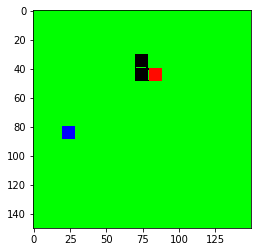

In [4]:
plt.imshow(env.step(snake_object1.RIGHT)[0])

In [5]:
# Initial population + configurations
n_individuals = 100
n_generations = 20
population = create_population(n_individuals)
percentage_to_save = .3
max_score = 0
best_moves = None


for i in range(n_generations):
    new_generation = []
    fitness = []

    for j in range(len(population)):
        fit_score, moves = calculate_fitness(population[j], env, display=False, save=False)
#         if fit_score > max_score:
#             best_moves = moves  
#             max_score = fit_score
        fitness.append(fit_score)
#     show_moves(best_moves)
    mating_pool = create_mating_pool(fitness, population, int(percentage_to_save * n_individuals))

    new_generation = []
    while len(new_generation) < n_individuals:
        sample = random.sample(mating_pool, 2)
        parent1, parent2 = sample[0], sample[1]
        child1, child2 = parent1.crossover(parent2)
        child1.mutate()
        child2.mutate()
        new_generation += [child1, child2]
    population = new_generation
#     max_score, best_moves = 0, None
    
    print("gen: " + str(i + 1) + ". Best result:", max(fitness))

max(population, key=lambda x: calculate_fitness(x, env)).save_model()

KeyboardInterrupt: 